# Semi-supervised AQI Classification — Co-Training

- Mục tiêu: chạy co-training theo **2 views** (mặc định: view theo pattern thời gian/station và phần còn lại).
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: tự thiết kế VIEW1_COLS / VIEW2_COLS và chứng minh view tốt.

In [1]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_co_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

# Optionally set explicit views (list of column names), otherwise None -> auto split
VIEW1_COLS = None
VIEW2_COLS = None

,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.536215,0.387145,324523,2298,0.9
1,2,0.533438,0.386239,322225,2219,0.9
2,3,0.531167,0.380904,320006,1695,0.9
3,4,0.534006,0.388312,318311,1560,0.9
4,5,0.532871,0.380877,316751,1287,0.9
5,6,0.527192,0.376080,315464,1270,0.9
6,7,0.528328,0.375486,314194,1329,0.9
7,8,0.526877,0.373432,312865,1126,0.9
8,9,0.526246,0.373510,311739,1334,0.9
9,10,0.525300,0.374854,310405,1447,0.9


Test accuracy: 0.4586407534041149
Test f1_macro: 0.330337931859929


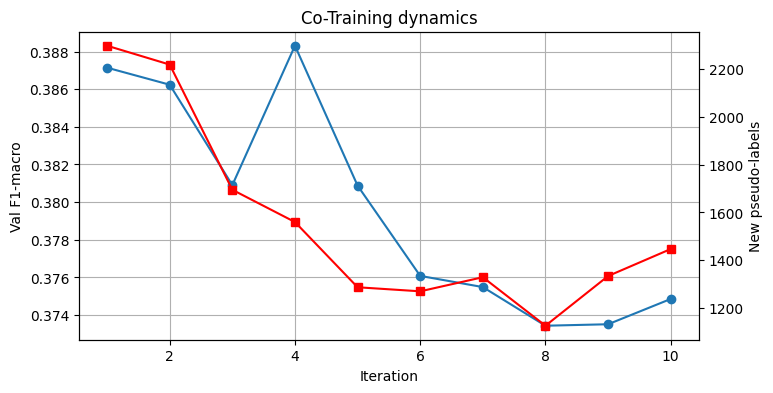

Saved metrics to: D:\air_guard_miniproject\data\runs\metrics_co_training.json


In [3]:
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- ĐOẠN FIX LỖI ĐƯỜNG DẪN (PATH) ---
PROJECT_ROOT = Path(".").resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
# -------------------------------------

from src.semi_supervised_library import (
    SemiDataConfig, CoTrainingConfig, run_co_training, add_alert_columns
)

# 1. Định nghĩa các tham số cấu hình (Đảm bảo khớp với các bước trước)
SEMI_DATASET_PATH = "data/processed/semi_labeled_data.parquet"
CUTOFF = "2017-01-01"
TAU = 0.90
MAX_ITER = 10
MAX_NEW_PER_ITER = 5000 # Giới hạn số nhãn mới mỗi vòng để tránh quá tải
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42
ALERT_FROM_CLASS = "Unhealthy"

# Định nghĩa 2 "Góc nhìn" (Views) cho Co-training
# View 1: Các chỉ số nồng độ chất ô nhiễm
VIEW1_COLS = ['PM10', 'SO2', 'NO2', 'CO', 'O3'] 
# View 2: Các chỉ số khí tượng môi trường
VIEW2_COLS = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Đường dẫn lưu kết quả
METRICS_PATH = "data/runs/metrics_co_training.json"
PRED_SAMPLE_PATH = "data/runs/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/runs/alerts_co_training_sample.csv"

# 2. Đọc dữ liệu
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

# 3. Cấu hình và chạy thuật toán Co-training
data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
ct_cfg = CoTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    max_new_per_iter=int(MAX_NEW_PER_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

# Chạy quy trình huấn luyện song song
out = run_co_training(df, data_cfg, ct_cfg, view1_cols=VIEW1_COLS, view2_cols=VIEW2_COLS)
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

# 4. Hiển thị kết quả
display(history)
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])

# Trực quan hóa diễn biến
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(history["iter"], history["val_f1_macro"], marker="o", label='Val F1')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val F1-macro")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(history["iter"], history["new_pseudo"], marker="s", color='r', label='New labels')
ax2.set_ylabel("New pseudo-labels")
plt.title("Co-Training dynamics")
plt.show()

# 5. Lưu kết quả
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
metrics_path.parent.mkdir(parents=True, exist_ok=True)

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump({"test_metrics": test_metrics, "history": out["history"]}, f, indent=2)

print("Saved metrics to:", metrics_path)